In [1]:
# Working with AIA, XRT and NuSTAR data in python

# So far just AIA and XRT for the 12 Sep 2020 event
# 26-04-2021 IGH

In [2]:
# Import some of the stuff we might need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import scipy.io as io
#  Using demreg from https://github.com/ianan/demreg/tree/master/python
from dn2dem_pos import dn2dem_pos
from dn2dem_pos_selfnorm import dn2dem_pos_selfnorm
import glob

import astropy.time
from astropy.coordinates import SkyCoord
from astropy import units as u
import sunpy.map

from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

In [3]:
# Load in the XRT data and grade map for the Sep 2020 data from sswidl make_xrt_for_python.pro

fdata='XRT_20200912_204028_Be_thin_Open_512.fits'
fgm='gm_XRT_20200912_204028_Be_thin_Open_512.fits'

xmap=sunpy.map.Map(fdata)
xgmmap=sunpy.map.Map(fgm)


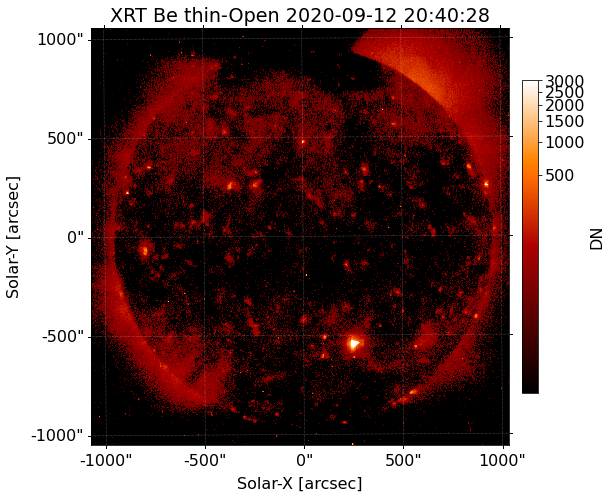

In [4]:
#  Plot the map to check looks ok
dmin=3
dmax=3e3

fig = plt.figure(figsize=(8, 8))
xmap.plot(norm=colors.PowerNorm(gamma=0.2,vmin=dmin,vmax=dmax))
plt.colorbar(fraction=0.035, pad=0.03,label='DN')
plt.show()


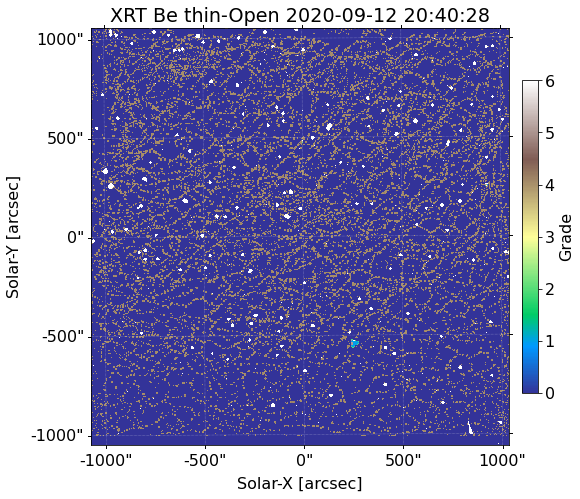

In [5]:
# Plot the grade map
fig = plt.figure(figsize=(8, 8))
xgmmap.plot(norm=colors.Normalize(vmin=0,vmax=6),cmap='terrain')
plt.colorbar(fraction=0.035, pad=0.03,label='Grade')
plt.show()

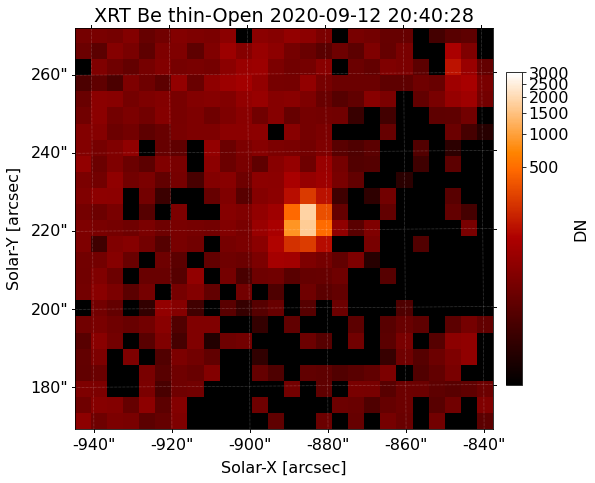

In [6]:
# Submap closer to the region of interest
bl=[-940*u.arcsec, 170*u.arcsec]
tr=[-840*u.arcsec, 270*u.arcsec]
bottom_left = SkyCoord(bl[0],bl[1], frame = xmap.coordinate_frame)
top_right = SkyCoord(tr[0],tr[1], frame=xmap.coordinate_frame)
sxmap = xmap.submap(bottom_left=bottom_left, top_right=top_right)

dmin=3
dmax=3e3
fig = plt.figure(figsize=(8, 8))
sxmap.plot(norm=colors.PowerNorm(gamma=0.2,vmin=dmin,vmax=dmax))
plt.colorbar(fraction=0.035, pad=0.03,label='DN')
plt.show()

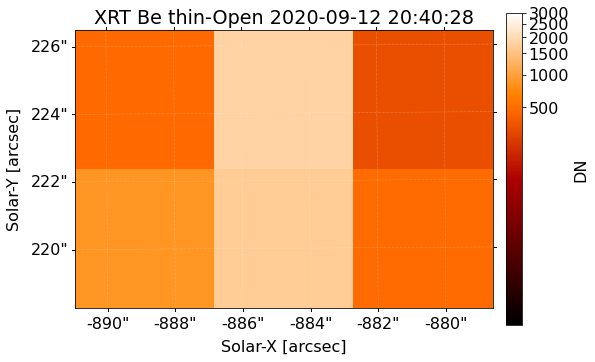

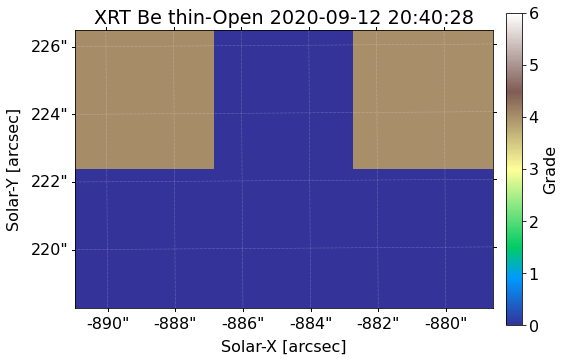

In [7]:
#  Get the XRT for just the region of interest
bl=[-890*u.arcsec, 219*u.arcsec]
tr=[-880*u.arcsec, 225*u.arcsec]
bottom_left = SkyCoord(bl[0],bl[1], frame = xmap.coordinate_frame)
top_right = SkyCoord(tr[0],tr[1], frame=xmap.coordinate_frame)
regxmap = xmap.submap(bottom_left=bottom_left, top_right=top_right)

dmin=3
dmax=3e3
fig = plt.figure(figsize=(8, 8))
regxmap.plot(norm=colors.PowerNorm(gamma=0.2,vmin=dmin,vmax=dmax))
plt.colorbar(fraction=0.035, pad=0.03,label='DN')
plt.show()

# Same for the grade map showing some grade 4 near feature => contamination spots
regxgmmap = xgmmap.submap(bottom_left=bottom_left, top_right=top_right)
fig = plt.figure(figsize=(8, 8))
regxgmmap.plot(norm=colors.Normalize(vmin=0,vmax=6),cmap='terrain')
plt.colorbar(fraction=0.035, pad=0.03,label='Grade')
plt.show()


In [8]:
#  What is the DN/s/px from the region???
dur=regxmap.exposure_time.value
# What pixel binning per dimension
chipsum=regxmap.meta['chip_sum']
#  Get a DN/s/px (non-binned pixels) for the region
xdnspx=np.mean(regxmap.data)/dur/chipsum**2
print(xdnspx, ' DN/s/px')

3.60276666469872  DN/s/px


In [9]:
# #  Now prep and get the AIA values
# #  Do all the prep first and save out the submaps
# ffa=sorted(glob.glob('aia.lev1*.fits'))
# # print(ffa)

# amaps=sunpy.map.Map(ffa)
# # Get the wavelengths of the maps, get index of sort for this list of maps and reorder
# wvn0 = [m.meta['wavelnth'] for m in amaps]
# srt_id = sorted(range(len(wvn0)), key=wvn0.__getitem__)
# amaps = [amaps[i] for i in srt_id]
# print([m.meta['wavelnth'] for m in amaps])

# # aiaprep the images, may take a while to run
# aprep=[]
# for m in amaps:
#     m_temp = update_pointing(m)
#     aprep.append(register(m_temp))
# #  Just save out the prepped submaps to quickly load in later
# for m in aprep:
#     bottom_left = SkyCoord(-940*u.arcsec,170*u.arcsec, frame=m.coordinate_frame)
#     top_right = SkyCoord(-840*u.arcsec,270*u.arcsec, frame=m.coordinate_frame)
#     mm = m.submap(bottom_left=bottom_left, top_right=top_right)
#     wvn="{0:d}".format(1000+mm.meta['wavelnth'])
#     wvn=wvn[1:]
#     mm.save('maps_prep_092021_'+wvn+'.fits',overwrite='True')



In [10]:
ffp=sorted(glob.glob('maps_prep_092021*.fits'))
aprep=sunpy.map.Map(ffp)

In [11]:
# Get the durations for the DN/px/s normalisation and
# wavenlength to check the order - should already be sorted above
wvn = [m.meta['wavelnth'] for m in aprep]
durs = [m.meta['exptime'] for m in aprep]
# Convert to numpy arrays as make things easier later
durs=np.array(durs)
wvn=np.array(wvn)
print(durs)
print(wvn)

[2.902044 2.901345 2.000162 1.999637 2.90119  2.900818]
[ 94 131 171 193 211 335]


3.15375e+17


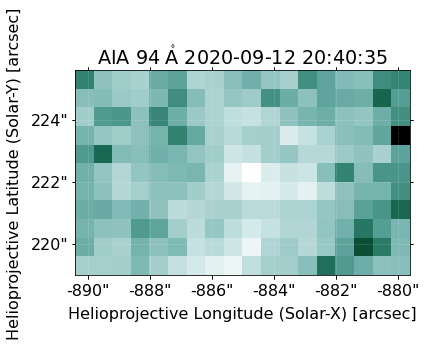

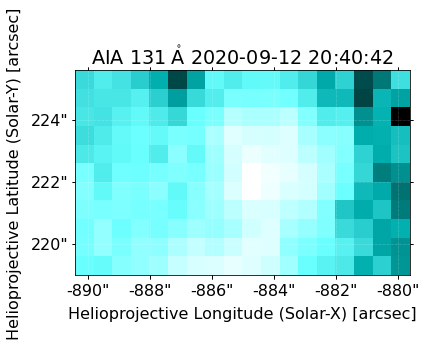

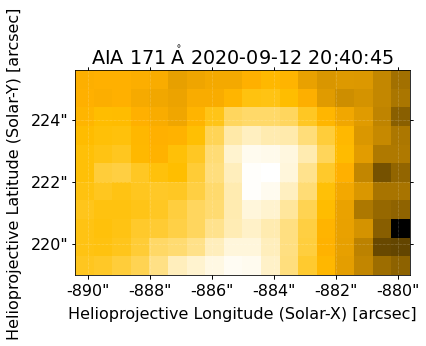

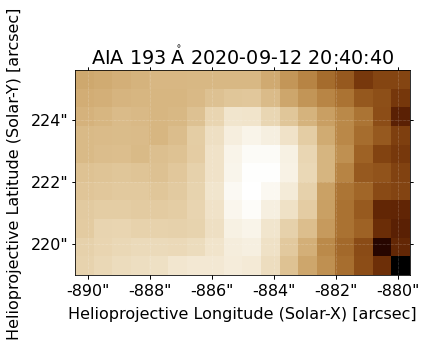

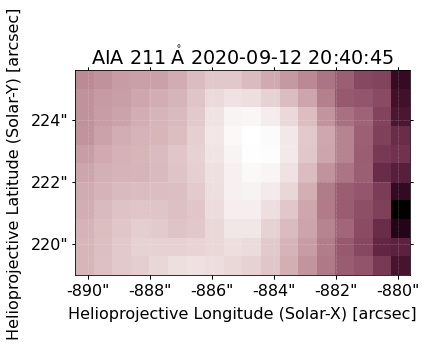

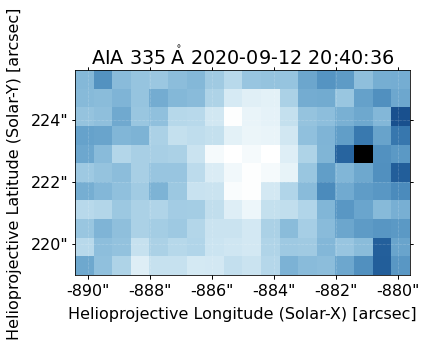

[5.67683, 36.71543781719263, 677.2892247243025, 568.7694418455856, 239.07170412209274, 6.793778390941739]


In [12]:
# Use the XRT region from above
# This is just a rough example so will need to refine these - got the correct AIA feature?
bl=[-890*u.arcsec, 219*u.arcsec]
tr=[-880*u.arcsec, 225*u.arcsec]

area=(tr[0].value-bl[0].value)*(tr[1].value-bl[1].value)*7.25e7*7.25e7  
print(area)

data_mean = []
num_pix = []
for m in aprep:
    bottom_left = SkyCoord(bl[0],bl[1], frame = m.coordinate_frame)
    top_right = SkyCoord(tr[0],tr[1], frame=m.coordinate_frame)
    sub_temp = m.submap(bottom_left=bottom_left, top_right=top_right)
    data_mean.append(np.mean(sub_temp.data))
    num_pix.append(sub_temp.data.size)
    sub_temp.plot()
    plt.show()
print(data_mean)

In [13]:
# Let's get the degradation correction factors
channels = [94,131,171,193,211,335] * u.angstrom
time=astropy.time.Time('2020-09-12T20:40:00', scale='utc')

# nc=len(channels)
# degs=np.empty(nc)
# for i in np.arange(nc):
#       degs[i]=degradation(channels[i],time,calibration_version=10)
# print(degs)

# As slow to compute here's the previously calculated for the above
degs=np.array([0.90317732, 0.50719532, 0.73993289, 0.49304311, 0.40223458, 0.17221724])
print(degs)

[0.90317732 0.50719532 0.73993289 0.49304311 0.40223458 0.17221724]


In [14]:
#  Correct the AIA data for the degradation
cor_data=data_mean/degs
print(data_mean)
print(cor_data)

# Get into DN/s/px for the DEM stuff
adn_in=cor_data/durs
print('DN/s/px: ',adn_in)

[5.67683, 36.71543781719263, 677.2892247243025, 568.7694418455856, 239.07170412209274, 6.793778390941739]
[   6.28539899   72.38914944  915.33872041 1153.58967666  594.35890401
   39.44888671]
DN/s/px:  [  2.16585241  24.95020394 457.63229199 576.8995456  204.86727998
  13.59922846]


In [15]:
#  Load in the AIA responses from sswidl make_aiaresp_forpy.pro
trin=io.readsav('aia_tresp_en.dat')

for i in np.arange(len(trin['channels'])):
    trin['channels'][i]=trin['channels'][i].decode("utf-8")
# print(trin['channels'])
chans=np.array(trin['channels'])

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,7))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]

In [16]:
#  Load in the XRT ones from sswidl make_xrt_tresp_forpy.pro
tr_sep20=io.readsav('xrt_tresp_20200912.dat')

filters=np.array(tr_sep20['filters'])
filters[0]=filters[0].decode('utf-8')
filters[1]=filters[1].decode('utf-8')
# print(filters)
units=tr_sep20['units'].decode('utf-8')
# print(units)
# date_sep20=astropy.time.Time(tr_sep20['date'].decode('utf-8'), format = 'isot')
# print(date_sep20.iso[:10])

In [17]:
#  Combine the AIA and XRT together
chanax=np.append(chans,filters[1])
print(chanax)
xtrint=10**np.interp(tresp_logt,tr_sep20['logt'],np.log10(tr_sep20['tr'][1]))
trmatrix[:,6]=xtrint

['A94' 'A131' 'A171' 'A193' 'A211' 'A335' 'Be-thin']


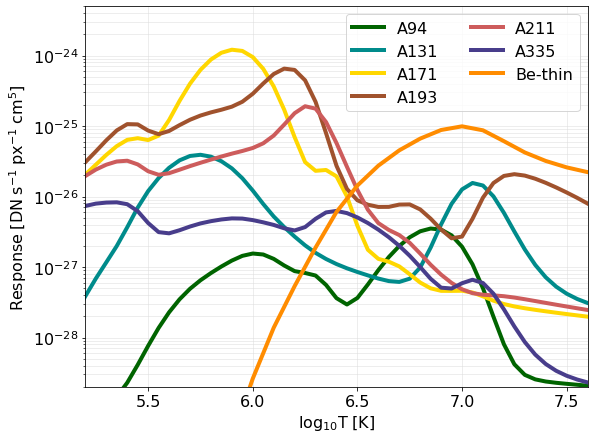

In [18]:
# Setup some colours
clrs=['darkgreen','darkcyan','gold','sienna','indianred','darkslateblue','darkorange']

# Do the plot
fig = plt.figure(figsize=(9, 7))
for i in np.arange(7):
    plt.semilogy(tresp_logt,trmatrix[:,i],label=chanax[i],color=clrs[i],lw=4)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{Response\;[DN\;s^{-1}\;px^{-1}\;cm^5]}$')
plt.ylim([2e-29,5e-24])
plt.xlim([5.2,7.6])
plt.legend(ncol=2,prop={'size': 16})
plt.rcParams.update({'font.size': 16})
plt.grid(True,which='both',lw=0.5,color='gainsboro')
plt.show()

In [19]:
# Now combine the AIA and XRT data together
dn_in=np.append(adn_in,xdnspx)
print(dn_in)
# Lets just assume some % error
edn_in=0.1*np.copy(dn_in)
print(edn_in)

[  2.16585241  24.95020394 457.63229199 576.8995456  204.86727998
  13.59922846   3.60276666]
[ 0.21658524  2.49502039 45.7632292  57.68995456 20.486728    1.35992285
  0.36027667]


In [20]:
# What temperature binning do we want for the DEM ?
temps=np.logspace(5.6,6.8,num=42)
dt=([temps[i+1]-temps[i] for i in np.arange(0,len(temps)-1)])
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

chisq:  1.084068063226403
dn_reg/dn_in:  [1.00918634 0.7671392  1.06772158 0.95914307 1.00839386 0.93359529]


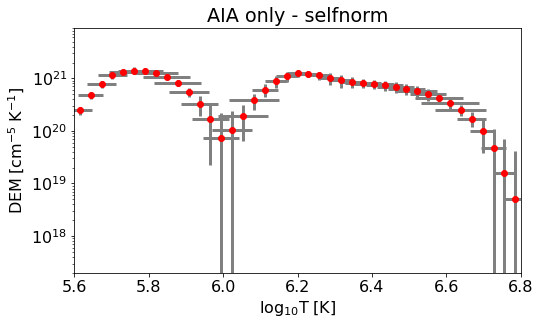

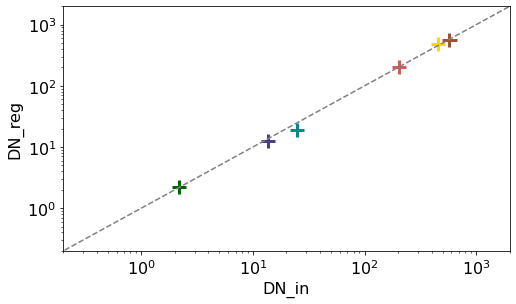

In [21]:
# Work out the DEM - AIA only self-weighted
dem,edem,elogt,chisq,dn_reg\
    =dn2dem_pos_selfnorm(dn_in[0:6],edn_in[0:6],trmatrix[:,0:6],tresp_logt,temps)
print('chisq: ',chisq)
print('dn_reg/dn_in: ',dn_reg[0:6]/dn_in[0:6])
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem,xerr=elogt,yerr=edem,fmt='or',ecolor='gray', elinewidth=3, capsize=0)
plt.title('AIA only - selfnorm')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e17,9e21])
plt.xlim(np.log10([np.min(temps),np.max(temps)]))
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.show()

fig = plt.figure(figsize=(8, 4.5))
plt.scatter(dn_in[0:6],dn_reg,color=clrs[0:6],marker='+',s=200,lw=3)
plt.plot([1e-1,1e4],[1e-1,1e4],color='grey',ls='dashed')
plt.xlabel('DN_in')
plt.ylabel('DN_reg')
plt.ylim([2e-1,2e3])
plt.xlim([2e-1,2e3])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xscale('log')
plt.show()

chisq:  11.849131407673196
dn_reg/dn_in:  [0.62611634 0.41147942 0.96346662 0.80737179 0.75110976 0.50830172
 1.03376199]


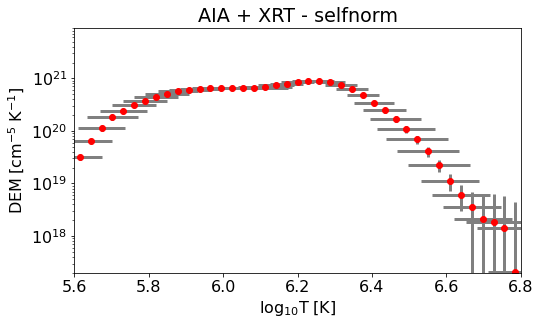

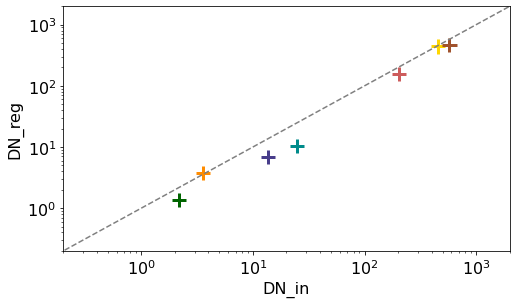

In [22]:
# Work out the DEM - AIA + XRT self-weighted
dem,edem,elogt,chisq,dn_reg\
    =dn2dem_pos_selfnorm(dn_in,edn_in,trmatrix,tresp_logt,temps)
print('chisq: ',chisq)
print('dn_reg/dn_in: ',dn_reg/dn_in)
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem,xerr=elogt,yerr=edem,fmt='or',ecolor='gray', elinewidth=3, capsize=0)
plt.title('AIA + XRT - selfnorm')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e17,9e21])
plt.xlim(np.log10([np.min(temps),np.max(temps)]))
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.show()

fig = plt.figure(figsize=(8, 4.5))
plt.scatter(dn_in,dn_reg,color=clrs,marker='+',s=200,lw=3)
plt.plot([1e-1,1e4],[1e-1,1e4],color='grey',ls='dashed')
plt.xlabel('DN_in')
plt.ylabel('DN_reg')
plt.ylim([2e-1,2e3])
plt.xlim([2e-1,2e3])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xscale('log')
plt.show()


chisq:  6.805424633499443
dn_reg/dn_in:  [0.68691167 0.61083995 1.06549675 0.90676558 0.84026065 0.56677959
 1.02703363]


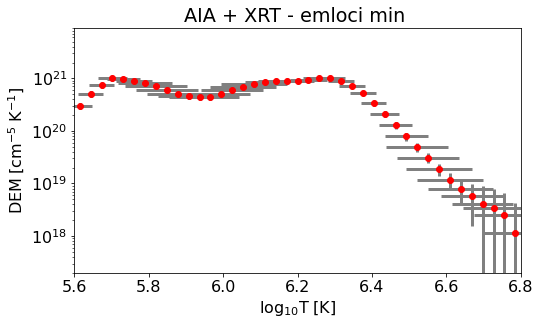

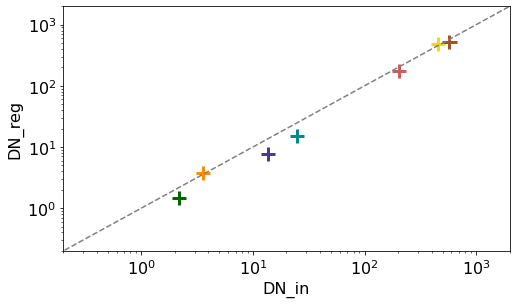

In [23]:
#  Use the min of the EM loci as an intial weighting to L
emloc=dn_in/trmatrix
emloc_int=np.zeros([len(dt),len(dn_in)])
for i in np.arange(len(dn_in)):
    emloc_int[:,i]=10**(np.interp(mlogt,tresp_logt,np.log10(emloc[:,i])))/dt
emloc_int_min=np.zeros(len(dt))
for i in np.arange(len(dt)):
    emloc_int_min[i]=np.min(emloc_int[i,:])
    
# Probably best just to smooth it a bit as well....
emloc_int_min_smth=np.convolve(emloc_int_min[1:-1],np.ones(5)/5)[1:-1] 

# Could do selfnorm here as well with the intial weighting and gets slightly different results
# dem,edem,elogt,chisq,dn_reg\
#     =dn2dem_pos_selfnorm(dn_in,edn_in,trmatrix,tresp_logt,temps,\
#                 dem_norm0=emloc_int_min_smth/np.max(emloc_int_min_smth))
dem,edem,elogt,chisq,dn_reg\
    =dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,\
                dem_norm0=emloc_int_min_smth/np.max(emloc_int_min_smth))

print('chisq: ',chisq)
print('dn_reg/dn_in: ',dn_reg/dn_in)
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem,xerr=elogt,yerr=edem,fmt='or',ecolor='gray', elinewidth=3, capsize=0)
# plt.semilogy(mlogt,emloc_int_min_smth)
plt.title('AIA + XRT - emloci min ')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e17,9e21])
plt.xlim(np.log10([np.min(temps),np.max(temps)]))
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.show()

fig = plt.figure(figsize=(8, 4.5))
plt.scatter(dn_in,dn_reg,color=clrs,marker='+',s=200,lw=3)
plt.plot([1e-1,1e4],[1e-1,1e4],color='grey',ls='dashed')
plt.xlabel('DN_in')
plt.ylabel('DN_reg')
plt.ylim([2e-1,2e3])
plt.xlim([2e-1,2e3])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xscale('log')
plt.show()


chisq:  2.4642436670243306
dn_reg/dn_in:  [0.79829174 0.74503281 1.10838966 0.9749539  1.00562174 0.76934239
 1.03453121]


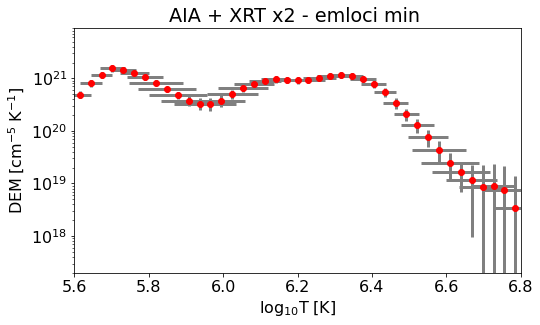

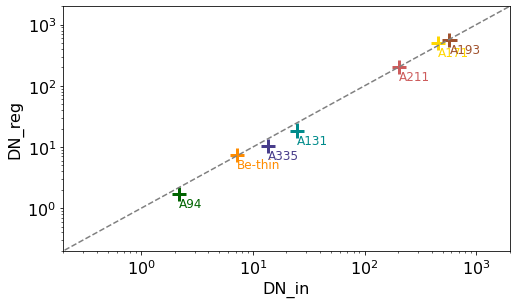

In [24]:
#  Maybe the XRT value is too small due to the contamination spots?
dn_in2=np.copy(dn_in)
dn_in2[6]=dn_in2[6]*2.0
edn_in2=0.1*np.copy(dn_in2)

#  Use the min of the EM loci as an intial weighting to L
emloc=dn_in2/trmatrix
emloc_int=np.zeros([len(dt),len(dn_in)])
for i in np.arange(len(dn_in)):
    emloc_int[:,i]=10**(np.interp(mlogt,tresp_logt,np.log10(emloc[:,i])))/dt
emloc_int_min=np.zeros(len(dt))
for i in np.arange(len(dt)):
    emloc_int_min[i]=np.min(emloc_int[i,:])
    
# Probably best just to smooth it a bit as well....
emloc_int_min_smth=np.convolve(emloc_int_min[1:-1],np.ones(5)/5)[1:-1] 

dem,edem,elogt,chisq,dn_reg\
    =dn2dem_pos(dn_in2,edn_in2,trmatrix,tresp_logt,temps,\
                dem_norm0=emloc_int_min_smth/np.max(emloc_int_min_smth))

print('chisq: ',chisq)
print('dn_reg/dn_in: ',dn_reg/dn_in2)
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem,xerr=elogt,yerr=edem,fmt='or',ecolor='gray', elinewidth=3, capsize=0)
# plt.semilogy(mlogt,emloc_int_min_smth)
plt.title('AIA + XRT x2 - emloci min ')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e17,9e21])
plt.xlim(np.log10([np.min(temps),np.max(temps)]))
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.show()

fig,ax = plt.subplots(figsize=(8, 4.5))
plt.scatter(dn_in2,dn_reg,color=clrs,marker='+',s=200,lw=3)
for i, lab in enumerate(chanax):
    ax.annotate(lab, (dn_in2[i], 0.6*dn_reg[i]),color=clrs[i],fontsize=12)
plt.plot([1e-1,1e4],[1e-1,1e4],color='grey',ls='dashed')
plt.xlabel('DN_in')
plt.ylabel('DN_reg')
plt.ylim([2e-1,2e3])
plt.xlim([2e-1,2e3])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xscale('log')
plt.show()
